In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
import warnings; warnings.simplefilter('ignore')
import statsmodels.api as sm
import sys
sys.path.append('../zdrojaky')
from tsplot import tsplot

# Téma: Stavová reprezentace modelů časových řad

## Stavový model s normálním šumem

Až doposud jsme uvažovali, že stavový model má šum libovolný, ale v mnoha ohledech "hodný" - centrovaný v nule, nezávislý, stejně rozdělený, s existujícími prvními dvěma momenty a nejlépe ještě symetrický.

Nyní předpoklady trochu zpřísníme:

>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + \varepsilon_t, \\
w_t &\sim \mathcal{N}(0, Q_t),\\
\varepsilon_t &\sim \mathcal{N}(0, R_t),
\end{aligned}
$$
>
> kde $x_t$ je **stav**, $u_t$ je **řídící veličina**, $w_t$ a $\varepsilon_t$ jsou **normálně rozdělený šum stavu** a **normálně rozdělený šum měření** a $A_t, B_t$ a $H_t$ jsou matice patřičných rozměrů.

### Věrohodnost (likelihood) $y_t$

#### Rozdělení $x_t$

Víme, že $x_t$ modelujeme rozdělením se střední hodnotou $\hat{x}_{t}^{-}$ a kovariancí $P_{t}^-$, nebo $\hat{x}_{t}^{+}$ a $P_{t}^+$, podle toho, zda již došlo ke korekčnímu kroku (datovému updatu) či nikoliv. Známe střední hodnotu a kovarianci, můžeme tedy tento odhad reprezentovat normální distribucí,

$$
x_t \sim \mathcal{N}(\hat{x}_t^-, P_t^-)\qquad\text{resp.}\qquad x_t \sim \mathcal{N}(\hat{x}_t^+, P_t^+).
$$

Pohledem na stavový model, konkrétně na rovnici pro pozorování

$$
y_t = H_t x_t + \varepsilon_t,\qquad
\varepsilon_t \sim \mathcal{N}(0, R_t),
$$

vidíme, že po dosazení apriorního odhadu $\hat{x}_t^-$ dostaneme

$$
y_t \sim \mathcal{N}(H_t \hat{x}_t^-, ?).
$$

Jelikož provádíme transformaci normálně rozdělené veličiny $x_t$ maticí $H_t$, už z první přednášky o Kalmanově filtru víme, že taková veličina bude mít rozptyl $H_t P_t^{-} H_t^\intercal$. Současně víme, že $y_t$ má rozptyl $R_t$ - viz o dvě rovnice výše, takže výsledný rozptyl predikce $\hat{y}_t$ je součtem obou rozptylů a platí

$$
\hat{y}_t \sim \mathcal{N}(H_t x_t^-, H_t P_t^- H_t + R_t).
$$

Známe tedy:

- hustotu pravděpodobnosti uvedeného rozdělení $\hat{y}_t$
- hodnotu získaného pozorování $y_t$, jež jsme naměřili

a můžeme se podívat na hodnotu věrohodnosti $y_t$ na uvedeném rozdělení, tj. hodnotu hustoty pravděpodobnosti pro $\hat{y}_t$ v bodě $y_t$.

#### Ilustrace

Podívejme se pro ilustraci na následující obrázek. V čase $t$ máme fixní distribuci $\mathcal{N}(H_t x_t^-, H_t P_t^- H_t + R_t)$, do které jsme dosadili a o které tedy víme vše. Přijde-li nám "fialové" pozorování, pak má věrohodnost - likelihood - tj. funkční hodnotu hustoty pravděpodobnosti větší, než kdybychom dostali pozorování modré. Pokud by toto bylo systematické pro všechna data, mohli bychom tvrdit, že model fituje "fialová" data lépe, než "modrá".

![ml-dvedata](img/ml-dvedata.jpg)

## Metoda maximální věrohodnosti graficky

Uvažujme, že máme pozorování $Y_1=5.1, Y_2=4.8, Y_3 = 4.6, Y_4=5, Y_5=5.5$. Ta nám vygeneroval jednoduchoučký proces ve tvaru

$$
Y_t = \underbrace{a}_{=5} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, 1).
$$

Jelikož jde o aditivní model, snadno vidíme, že $Y_t \sim \mathcal{N}(a, 1)$.

Připomeňme, že při nezávislosti $Y_t$ počítáme věrohodnost (likelihood) odhadovaného $a$ jako součin, v našem normálním případě

$$
\begin{aligned}
f(y_1, \ldots, y_5|a) &= f(y_1|a) \cdot f(y_2|a) \cdots f(y_5|a)\\
&= \mathcal{N}(y_1; a, 1) \cdots \mathcal{N}(y_5; a, 1),
\end{aligned}
$$

kde jednotlivé faktory jsou hustoty normálního rozdělení centrované v $a$ a s rozptylem 1, viz první vztah.

Máme **iterativně** odhadovat $a$ metodou maximální věrohodnosti, ostatní parametry jsou známé. To znamená, že začneme z nějaké hodnoty a budeme postupně iterovat, dokud roste věrohodnost. Graficky by to vypadalo nějak takto - začneme od $a=4$, zkusíme $a=5$ a $a=6$. Pro šestku už bychom se museli vracet do okolí pětky, má-li věrohodnost růst.

![ml-graficky](img/ml-graficky.png)

(jinak řečeno, "šoupeme" s gausovkou vpravo vlevo, dokud není součin "tykadel" maximální :))

Jelikož jde o jednoduchý příkládek, můžeme snadno určit, že bychom z dat odhadovali $a$ jako průměr:

In [2]:
Y = np.array([5.1, 4.8, 4.6, 5, 5.4])
print("Průměr Y: {0}".format(Y.mean()))

Průměr Y: 4.9799999999999995


Zkusme to nyní **iterativně** - budeme počítat logaritmy věrohodností, tj. **loglikelihoody**,  kvůli numerické stabilitě - likelihoody jsou malá čísla a když bychom jich pár ponásobili, velmi rychle skončíme s numerikou na nule. Využijeme funkci `minimize()` ze scipy a protože chceme maximalizovat, přidáme k likelihoodu znaménko mínus:

In [4]:
def negative_loglikelihood(a):
    loglikelihoods = norm.logpdf(Y, loc=a, scale=1)
    return -np.sum(loglikelihoods)

from scipy.optimize import minimize
res = minimize(negative_loglikelihood, x0=0, options={'disp': True})
print(res)

Optimization terminated successfully.
         Current function value: 4.778693
         Iterations: 3
         Function evaluations: 8
         Gradient evaluations: 4
      fun: 4.778692666023371
 hess_inv: array([[0.19999999]])
      jac: array([-2.38418579e-07])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([4.97999995])


To je slušné. V takto jednoduchém příkladě bychom samozřejmě odhadovali $a$ metodou maximální věrohodnosti analyticky, ale optimalizační postup využijeme záhy. 

# Stavová reprezentace časových řad

AR, MA, ARMA, ARIMA, SARIMA a ostatní modely je možné reprezentovat pomocí stavových rovnic a následně odhadovat parametry původních modelů s využitím Kalmanova filtru. Oproti dosavadní práci se stavovými modely je zde ovšem několik specifik:

1. Stavový model nemá v případě časových řad přímočarou **interpretaci**. V případě fyzikálních a jiných stavových modelů, jimiž jsme se zabývali doposud, vznikaly stavové rovnice - resp. matice a vektory - přímočarým přepisem stávajících (např. fyzikálních) rovnic. To u časových řad neplatí. Stejně tak stav měl jasnou interpretaci, což bohužel zpravidla u časových řad rovněž neplatí, do stavu totiž schováme různé veličiny.
2. Stavové modely doposud neměly **parametry**, tj. neznámé s pevnou hodnotou - odhadovali jsme jen časově proměnné stavy. V případě časových řad ale parametry máme, např. AR a MA koeficienty. Ty nalezneme v různých maticích a vektorech - někdy v matici $A$, jindy ve stavu $x_t$, popř. na dalších místech.
3. Odhadovat potřebujeme **parametry** příslušného modelu časové řady. To budeme dělat stejně jako dříve **metodou maximální věrohodnosti**.
4. **Kalmanův filtr** nebude sloužit jako estimátor stavů, ale bude počítat **věrohodnost**, kterou chceme maximalizovat přes **parametry**. Výhoda totiž je, že Kalmanův filtr počítá věrohodnost velmi efektivně - sekvenčně.

**V praxi to potom vypadá takto:**

1. **Sestavíme** stavový model.
2. Nastavíme **počáteční odhady parametrů** pro časovou řadu (např. $\phi, \theta$). Tím máme model kompletní.
3. **Kalmanovým filtrem spočítáme věrohodnost** nastavených odhadů při pozorovaných datech $Y_t$.
4. **Optimalizací** nastavíme nové odhady a vrátíme se do bodu 3.

K optimalizaci lze použít různé numerické metody (BFGS, gradientní metody...).

**Role Kalmanova filtru zde nespočívá v odhadování stavů - ty známe, resp. máme do nich něco dosazeno - ale JEN v pohodlném počítání věrohodnosti (likelihoodu) parametrů při pozorovaných datech $Y_t$.** Neboli: dosadíme do stavového modelu odhad AR a MA koeficientů (nějaká čísla), spočteme věrohodnost, dosadíme jiný odhad (jiná čísla) atd. a snažíme se dostat k co nejvyšší věrohodnosti.

## Výhody stavové reprezentace

Stavová reprezentace má - navzdory své nesnadné interpretaci - řadu výhod:

- Je relativně snadné uvažovat časově proměnné parametry, strukturní změny, přepínání parametrů aj.
- Umí dobře pracovat s chybějícími daty - v Kalmanově filtru se udělá jen predikční krok, vynechá se korekční (datový update).
- Lze snadno pracovat s daty, jež nechodí ve fixních časových periodách. Buď se tomu model přizpůsobí, nebo se v mezidobích uvažují "chybějící data".
- Je možné využít i data z jiných zdrojů, která s modelovanými korelují (data fusion).
- Do stavové proměnné lze přidat další interpretovatelné komponenty (vzpomeňme na odhady rychlosti v 2D trackingu).
- Je možné snadno vložit nelineární vliv proměnných.
- A mnohé další.

Stavová reprezentace je natolik univerzální, že mnozí autoři tvrdí, že nemá nevýhod, nanejvýš jen potřebu občasných algebraických "kouzel" :-)

# Vybrané příklady

Níže následují vybrané příklady stavové reprezentace populárních modelů. Je důležité podotknout, že tyto reprezentace nejsou jednoznačné - modely lze zpravidla přepsat do stavové reprezentace celou řadou způsobů, z nichž některé jsou výhodnější než jiné.

## Náhodná procházka s driftem

Uvažujme proces náhodné procházky s konstantním driftem $c$, započatý z hodnoty $Y_0 = 0$ a šumem $\varepsilon_t\sim \mathcal{N}(0, \sigma^2)$ ve tvaru

$$
Y_t = Y_{t-1} + c + \varepsilon_t.
$$

Zavedeme-li
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ c
\end{bmatrix},
\qquad
\mathbf{w}_t =
\begin{bmatrix}
\varepsilon_t \\ 0
\end{bmatrix},
$$

potom 

$$
\begin{aligned}
Y_t &=
[1, 0]\ \mathbf{X}_t,\\
\mathbf{X}_t 
&=
\begin{bmatrix}
1 & 1 \\
0 & 1
\end{bmatrix}
\mathbf{X}_{t-1}
+
\mathbf{w}_t.
\end{aligned}
$$

## Sezónní model

Jednoduchý sezónní model předpokládá komponenty $Y_t$ opakující se s periodou $s$ a které se mezi dvěma "sezónami" vysčítají do nuly (proč?). To jest,

$$
Y_{t+s} = Y_t, \qquad \sum_{i=1}^s Y_{t+i} = 0 \qquad \text{pro všechna $t$}. 
$$

Máme-li tedy hodnoty $Y_1,\ldots, Y_{s-1}$, můžeme takovou časovou řadu vygenerovat pomocí

$$
Y_s = - Y_1 -\ldots - Y_{s-1} \qquad\text{a}\qquad Y_{t+s}=Y_t,\qquad t=1,2,\ldots
$$

Přidáme-li aditivní šum $\varepsilon_t\sim\mathcal{N}(0, \sigma^2)$, dostaneme sezónní model

$$
Y_t = -Y_{t-s+1} - Y_{t-s+2} - \ldots - Y_{t-1} + \varepsilon_t, \qquad t=s,s+1,\ldots
$$

To nás zavede na model kde

$$
\mathbf{X}_t =
\begin{bmatrix}
Y_t \\ Y_{t-1} \\ \vdots \\ Y_{t-s+1}
\end{bmatrix}
$$

a výsledný stavový model

$$
\begin{align}
Y_t &= [1, 0, \ldots, 0]\ \mathbf{X}_t \\
\mathbf{X}_t &= 
\begin{bmatrix}
-1 & -1 & -1 & -1 & \ldots & -1 \\
1 & 0 & 0 & 0 & \ldots & 0 \\
0 & 1 & 0 & 0 & \ldots & 0 \\
0 & 0 & 1 & 0 & \ldots & 0\\
\vdots & \vdots & \ddots & \ddots & \ddots &\vdots \\
0 & 0 & \ldots & 0 & 1 & 0
\end{bmatrix}
\mathbf{X}_{t-1}
+ \begin{bmatrix}
\varepsilon_t \\ 0 \\ 0 \\ 0 \\ \vdots \\ 0
\end{bmatrix}
\end{align}
$$

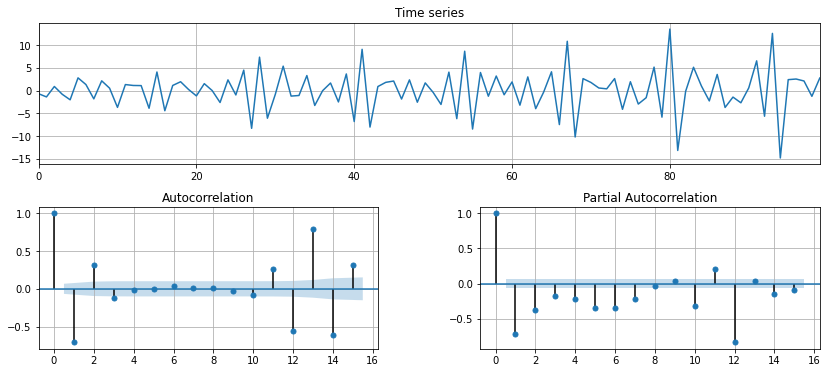

In [7]:
from seasonalitymodel import SeasonalityModel
np.random.seed(12)
data = np.zeros(12)                             # endog, v simulaci nepotřebné
mod = SeasonalityModel(data)                    # viz ../zdrojaky/
initstate = np.random.uniform(-1, 1, size=12)   # počáteční stav X_t
initstate[-1] = -np.sum(initstate[:11])         # podmínka sumy do 0, viz výše
noise_var = 1.6
d = mod.simulate(params=noise_var, 
                 nsimulations=100, 
                 initial_state=initstate)       # simulace
tsplot(d)
plt.show()

In [9]:
# Trefí se odhad do variance šumu?
model = SeasonalityModel(d)
res = model.fit(start_params=0)      #!BUG! https://github.com/statsmodels/statsmodels/issues/3567
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:               SeasonalityModel   Log Likelihood                -146.201
Date:                Tue, 10 Nov 2020   AIC                            294.402
Time:                        15:34:17   BIC                            296.879
Sample:                             0   HQIC                           295.400
                                - 100                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
sigma2.process     1.6240      0.250      6.486      0.000       1.133       2.115
Ljung-Box (L1) (Q):                   4.13   Jarque-Bera (JB):                 0.28
Prob(Q):                           

## AR(2)

Autoregresní model druhého řádu má tvar

$$
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Označme
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ Y_{t-1}
\end{bmatrix}
,\qquad
\mathbf{w}_t =
\begin{bmatrix}
\varepsilon_t \\ 0
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi_1 & \phi_2 \\
1 & 0
\end{bmatrix}
\mathbf{X}_{t-1} + \mathbf{w}_t.
\end{align}
$$

Zamysleme se zde nad odhadem:

1. Sestavíme stavový model - to teď máme.
2. Zvolíme vhodné počáteční odhady $\phi_1, \phi_2, \sigma^2$, ty dosadíme.
3. Kalmanovým filtrem spočítáme věrohodnost (likelihood) pozorovaných dat.
4. Upravíme hodnoty odhadů $\phi_1, \phi_2, \sigma^2$ a znovu bod 3.

## AR(2) ještě jednou

Tak ještě jednou...

$$
Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Označme
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ \phi_2 Y_{t-1}
\end{bmatrix}
,\qquad
\mathbf{w}_t =
\begin{bmatrix}
\varepsilon_t \\ 0
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi_1 & 1 \\
\phi_2 & 0
\end{bmatrix}
\mathbf{X}_{t-1} + \mathbf{w}_t.
\end{align}
$$

## AR(p)

Pro obecný řád máme

$$
Y_t = \phi_1 Y_{t-1} + \ldots + \phi_p Y_{t-p} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Označme
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ Y_{t-1} \\ \vdots \\ Y_{t-p+1}
\end{bmatrix}
,\qquad
\mathbf{w}_t =
\begin{bmatrix}
\varepsilon_t \\ 0 \\ \vdots \\ 0
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 0, \ldots, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi_1 & \phi_2 & \ldots & \phi_{p-1} & \phi_p \\
1 & 0 & \ldots & 0 & 0 \\
0 & 1 & \ldots & 0 & 0 \\
\vdots & & \ddots & \vdots & \vdots \\
0 & \ldots & 0 & 1 & 0
\end{bmatrix}
\mathbf{X}_{t-1} + \mathbf{w}_t.
\end{align}
$$


### ARMA(1, 1)

ARMA model prvních řádů bez konstanty má tvar

$$
Y_t = \phi Y_{t-1} + \theta \varepsilon_{t-1} + \varepsilon_t, \qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
$$

Označme
$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ \theta \varepsilon_{t}
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi & 1 \\
0 & 0
\end{bmatrix}
\mathbf{X}_{t-1} + 
\begin{bmatrix}
1 \\ \theta
\end{bmatrix} \varepsilon_t.
\end{align}
$$

### ARMA(p, q)

Následující varianta stavové reprezentace obecného ARMA modelu byla navrhnuta Harveyem a patří mezi nejpopulárnější pro svoji mnohostrannost. Existují i jiné varianty, např. [Hamiltonova](https://stats.stackexchange.com/questions/260542/state-space-representation-of-armap-q-from-hamilton).

Hledáme tedy reprezentaci modelu

$$
\begin{align}
Y_t &= \phi_1 Y_{t-1} + \ldots + \phi_p Y_{t-p} + \theta_1 \varepsilon_{t-1} + \ldots + \theta_q \varepsilon_{t-q} + \varepsilon_t \\ 
&= \sum_{i=1}^r \phi_i Y_{t-i} + \sum_{i=1}^{r-1}\theta_i \varepsilon_{t-j},
\qquad \varepsilon_t \sim \mathcal{N}(0, \sigma^2)
\end{align}
$$

kde $r=\max(p, q+1)$, $\theta_i=0$ pro $q < i \leq r$, $\phi_i=0$ pro $p<i\leq r$, jinými slovy, přebytečné koeficienty jsou nula.

Zaveďme

$$
\mathbf{X}_t = 
\begin{bmatrix}
Y_t \\ 
\phi_2 Y_{t-1} +\ldots + \phi_r Y_{t-r+1} 
    + \theta_1 \varepsilon_{t} + \ldots + \theta_{r-1}\varepsilon_{t-r+2} \\
\phi_3 Y_{t-1} +\ldots + \phi_r Y_{t-r+2} 
    + \theta_2 \varepsilon_{t} + \ldots + \theta_{r-1}\varepsilon_{t-r+3} \\
\vdots \\ 
\theta_{r} Y_{t-1} + \theta_{r-1}\varepsilon_{t}
\end{bmatrix}.
$$

Potom

$$
\begin{align}
Y_t &= [1, 0, \ldots, 0]\, \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
\phi_1 & 1 & 0 & \ldots & 0 \\
\phi_2 & 0 & 1 & \ddots & \vdots \\
\vdots & \vdots & \ddots & \ddots & 0 \\
\phi_{r-1} & 0 & \ldots & 0 & 1 \\
\phi_r & 0 & 0 & \ldots & 0
\end{bmatrix}
\mathbf{X}_{t-1} + 
\begin{bmatrix}
1 \\ \theta_1 \\ \vdots \\ \theta_{r-1}
\end{bmatrix}
\varepsilon_t
\end{align}
$$

### ARIMA(2,1,1)

Autoregresní model 2. řádu s modelem klouzavých průměrů 1. řádu a diferencemi 1. řádu - používáme jej pro (lineárně) nestacionární modely ARMA(2,1). Zkusme se tedy na něj podívat blíže.

Vzpomeňme, že diferencování prvního řádu ($d=1$) odpovídá transformaci časové řady ve tvaru

$$
Y_t^* = Y_t - Y_{t-1}.
$$

Na této transformované veličině nasadíme ARMA(2,1) model

$$
Y_t^* = \phi_1 Y_{t-1}^* - \phi_2 Y_{t-1}^* + \theta_1 \varepsilon_{t-1} + \varepsilon_t.
$$

Zavedeme-li

$$
\mathbf{X}_t =
\begin{bmatrix}
Y_{t-1} \\
Y_t^* \\
\phi_2 Y_{t-1}^* + \theta_1 \varepsilon_t
\end{bmatrix},
$$

potom

$$
\begin{align}
Y_t &= [1, 1, 0]\ \mathbf{X}_t \\
\mathbf{X}_t &=
\begin{bmatrix}
1 & 1 & 0 \\
0 & \phi_1 & 1 \\
0 & \phi_2 & 0
\end{bmatrix}
\mathbf{X}_{t-1}
+
\begin{bmatrix}
0 \\ 1 \\ \theta_1
\end{bmatrix}
\varepsilon_t.
\end{align}
$$

Tento model je přímočaré zobecnit na libovolné řády $p, q$. Model s vyššími diferencemi je třeba odvodit zvlášť. To v předmětu vynecháme, zvídavý student je odkázán na literaturu.

# Doporučená literatura

[1] J. Durbin, S.J. Koopman. 2012. Time Series Analysis by State Space Methods: Second Edition. Oxford University Press.

[2] A.C. Harvey. 1993. Time Series Models: Second Edition.

[3] M. West, J. Harrison. 1997. Bayesian Forecasting and Dynamic Models: Second Edition. Springer.